## Grupowanie miejsc wiążących ligandy - badanie zróżnicowania miejsc wążących na przykładzie struktur krystalicznych:

In [1]:
# To jest biblioteka którą opracowałem w ramch projektu magisterskiego.
# Daje ona dostęp do funkcjonalności dostępnych w bibliotece voro++ 
# (https://math.lbl.gov/voro++/) z poziomu Pythona. Biblioteka jest 
# napisana jako natywne rozszerzenie do Pythona - kod biblioteki nie 
# jest napisany w Pythonie (C++/Rust).
import Voronoi3D

from Bio.PDB import PDBParser
import numpy as np
import glob
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [2]:
# Buduję listę skrótów aminokwasów (nazwy reszt w PDB występują w postaci skrótów 3-literowych)
AMINOACIDS = set(
    "ALA CYS ASP GLU PHE GLY HIS ILE LYS LEU MET ASN PRO GLN ARG SER THR VAL TRP TYR".split())


In [3]:
# Każdemu aminokwasowi przypisuję jego wektor embedingowy. Wektory są budowane 
# z wartości numerycznych następujących własności fizyko-chemicznych:
# masa, objętość, hydrofobowość, punkt izoelektryczny (odpowiednio).
embeddings = {
    "ALA": [89.09404, 88.6, 1.8, 6.11],
    "CYS": [121.15404, 108.5, 2.5, 5.05],
    "ASP": [133.10384, 111.1, -3.5, 2.85],
    "GLU": [147.13074, 138.4, -3.5, 3.15],
    "PHE": [165.19074, 189.9, 2.8, 5.49],
    "GLY": [75.06714, 60.1, -0.4, 6.06],
    "HIS": [155.15634, 153.2, -3.2, 7.60],
    "ILE": [131.17464, 166.7, 4.5, 6.05],
    "LYS": [146.18934, 168.6, -3.9, 9.60],
    "LEU": [131.17464, 166.7, 3.8, 6.01],
    "MET": [149.20784, 162.9, 1.9, 5, 74],
    "ASN": [132.11904, 114.1, -3.5, 5, 41],
    "PRO": [115.13194, 112.7, -1.6, 6.30],
    "GLN": [146.14594, 143.8, -3.5, 5.65],
    "ARG": [174.20274, 173.4, -4.5, 10.76],
    "SER": [105.09344, 89.0, -0.8, 5.68],
    "THR": [119.12034, 116.1, -0.7, 5.60],
    "VAL": [117.14784, 140.0, 4.2, 6.00],
    "TRP": [204.22844, 227.8, -0.9, 5.89],
    "TYR": [181.19124, 193.6, -1.3, 5.64]
}

min_mass = min([vec[0] for vec in embeddings.values()])
max_mass = max([vec[0] for vec in embeddings.values()])

min_volume = min([vec[1] for vec in embeddings.values()])
max_volume = max([vec[1] for vec in embeddings.values()])

min_hydro = min([vec[2] for vec in embeddings.values()])
max_hydro = max([vec[2] for vec in embeddings.values()])

min_pi = min([vec[3] for vec in embeddings.values()])
max_pi = max([vec[3] for vec in embeddings.values()])

# Embeddingi w postaci znormalizowanej.
EMBEDDINGS = {key: np.array([(vec[0] - min_mass) / (max_mass - min_mass), (vec[1] - min_volume) / (max_volume - min_volume), (vec[2] - min_hydro) / (max_hydro - min_hydro), (vec[3] - min_pi) / (max_pi - min_pi)])
              for key, vec in embeddings.items()}


In [4]:
# Ta funkcja służy do wczytania struktury, wyznaczenia jej diagramu Woronoja,
# znalezienia komórek opisujących kieszenie wiążące konkretny ligand (cząsteczek
# może kilka) i finalnie wyznaczenia wektorów reprezentujących te kieszenie
# wiążące.
def vectorize_ligands(structure_path, ligand_name, total_atoms):
    structure_name = structure_path.split("\\")[-1].split(".")[0][3:]

    # Wczytanie struktury, utworzenie diagramu Woronoja
    parser = PDBParser()
    structure = parser.get_structure("STRUCTURE", structure_path)

    coords = [atom.get_coord() for atom in structure.get_atoms()]

    min_x = min(coords, key=lambda coord: coord[0])[0]
    max_x = max(coords, key=lambda coord: coord[0])[0]

    min_y = min(coords, key=lambda coord: coord[1])[1]
    max_y = max(coords, key=lambda coord: coord[1])[1]

    min_z = min(coords, key=lambda coord: coord[2])[2]
    max_z = max(coords, key=lambda coord: coord[2])[2]

    container = Voronoi3D.RectangularContainer(
        min_x, max_x, min_y, max_y, min_z, max_z)

    for residue in structure.get_residues():
        for atom in residue.get_atoms():
            if atom.get_name()[0] != "H" and residue.get_resname() != "HOH":
                container.add(atom.get_serial_number(), *atom.get_coord(), residue=residue.get_resname(),
                              atom=atom.get_name(), seg_id=residue.get_full_id()[3][1])

    diagram = Voronoi3D.Diagram(container)

    # ---------------------------------------------------------------------------------

    # Wybranie komórek zawierających ligand

    ligands_cells = []
    prev_res = -1

    for cell in diagram:
        if cell.generator.residue == ligand_name:
            if cell.generator.seg_id == prev_res:
                ligands_cells[-1].append(cell)
            else:
                ligands_cells.append([cell])
                prev_res = cell.generator.seg_id

    # ---------------------------------------------------------------------------------

    # Wyznaczenie sąsiadów ligandów (reszt aminokwasowych dookoła liganda)

    ligands_neighbors = []
    ligands_volumes_surfaces = []

    for ligand in ligands_cells:
        if len(ligand) == total_atoms:
            cells_ids = set([cell.generator.id for cell in ligand])
            ligand_atoms = {cell.generator.atom: [] for cell in ligand}

            volume = 0.0
            surface = 0.0
            for cell in ligand:
                volume += cell.volume

                for face in cell:
                    if face.neighbor not in cells_ids:
                        surface += face.area
                        residue = diagram.cell(face.neighbor).generator.residue
                        if residue in AMINOACIDS:
                            ligand_atoms[cell.generator.atom].append(residue)

            ligands_neighbors.append(ligand_atoms)
            ligands_volumes_surfaces.append((volume, surface))

    # ---------------------------------------------------------------------------------

    # Wektoryzacja znalezionych kieszeni wiążących

    vectors = []

    for (volume, surface), ligand in zip(ligands_volumes_surfaces, ligands_neighbors):
        atoms = [(atom, neighbors) for atom, neighbors in ligand.items()]
        atoms.sort(key=lambda x: x[0])

        vector = []

        for atom, neighbors in atoms:
            if len(neighbors) != 0:
                vector.append(sum([EMBEDDINGS[res]
                              for res in neighbors]) / len(neighbors))
            else:
                vector.append(np.zeros(len(EMBEDDINGS["GLY"])))

        vector = np.vstack(vector)
        vectors.append((structure_name, volume, surface, vector.flatten()))

    return vectors


### Wyniki grupowania dla 3 typów ligandów (CLR, NADPH, ATP):

### CLR:

In [5]:
ligand = "CLR"
pdb_files = glob.glob(f"..\\data\\{ligand}\\*")

vectors = []

for pdb_file in pdb_files:
    vectors += vectorize_ligands(pdb_file, ligand, 28)


c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4717.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4746.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4775.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4826.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4870.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\P

In [6]:
# Filtrowanie wyznaczonych miejsc wiązania ze względu na objetość.
# Bardzo duże objętości wskazują na słabo ograniczone miejsca wiązania.
vectors_reshape = np.vstack([vector[3]
                            for vector in vectors if vector[1] < 6000])
vectors_names = [vector[0] for vector in vectors if vector[1] < 6000]

print(f"Liczba znalezionych miejsc wiązania CLR: {len(vectors)}" )
print(f"Liczba miejsc po odfiltrowaniu: {len(vectors_reshape)}")


Liczba znalezionych miejsc wiązania CLR: 254
Liczba miejsc po odfiltrowaniu: 209


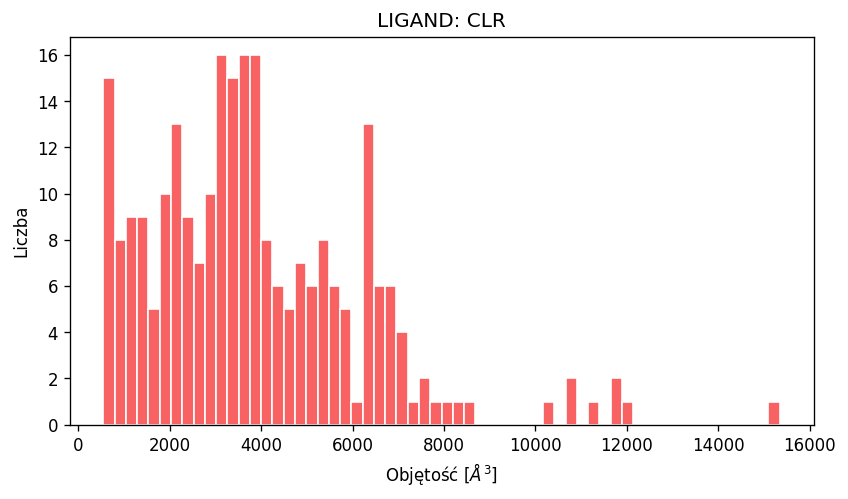

In [7]:
volumes = [vec[1] for vec in vectors]

fig, ax = plt.subplots()
fig.set_size_inches((8, 4.2))
fig.set_dpi(120)

ax.hist(volumes, bins=60, color=(249 / 255, 98 / 255,
        98 / 255), edgecolor="white", linewidth=1)
ax.set_xlabel(r"Objętość $[Å^3]$")
ax.set_ylabel("Liczba")
ax.set_title("LIGAND: CLR")
plt.show()


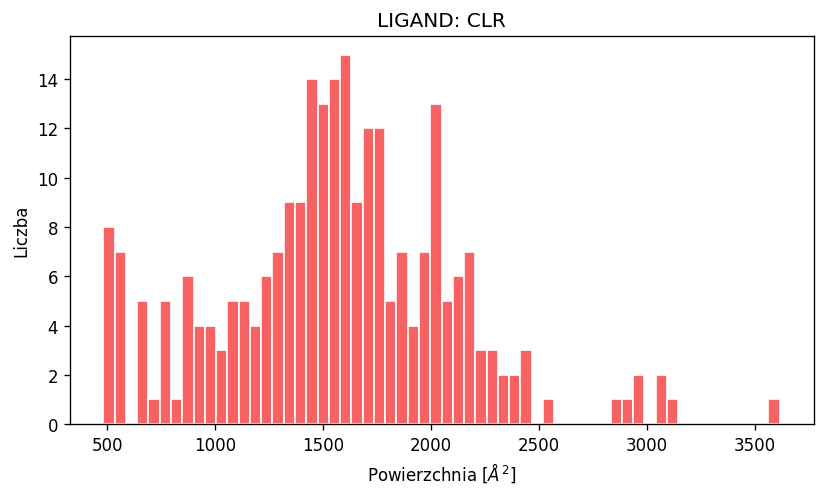

In [8]:
surfaces = [vec[2] for vec in vectors]

fig, ax = plt.subplots()
fig.set_size_inches((8, 4.2))
fig.set_dpi(120)

ax.hist(surfaces, bins=60, color=(249 / 255, 98 / 255,
        98 / 255), edgecolor="white", linewidth=1)
ax.set_xlabel(r"Powierzchnia $[Å^2]$")
ax.set_ylabel("Liczba")
ax.set_title("LIGAND: CLR")
plt.show()


In [9]:
# Redukcja wymiarowości do 12 wymiarów.
pca = PCA(12)
vectors_pca = pca.fit_transform(vectors_reshape)

total_var = round(np.sum(pca.explained_variance_ratio_) * 100, 1)

print(f"Zachowana wariancja: {total_var}%")


Zachowana wariancja: 81.7%


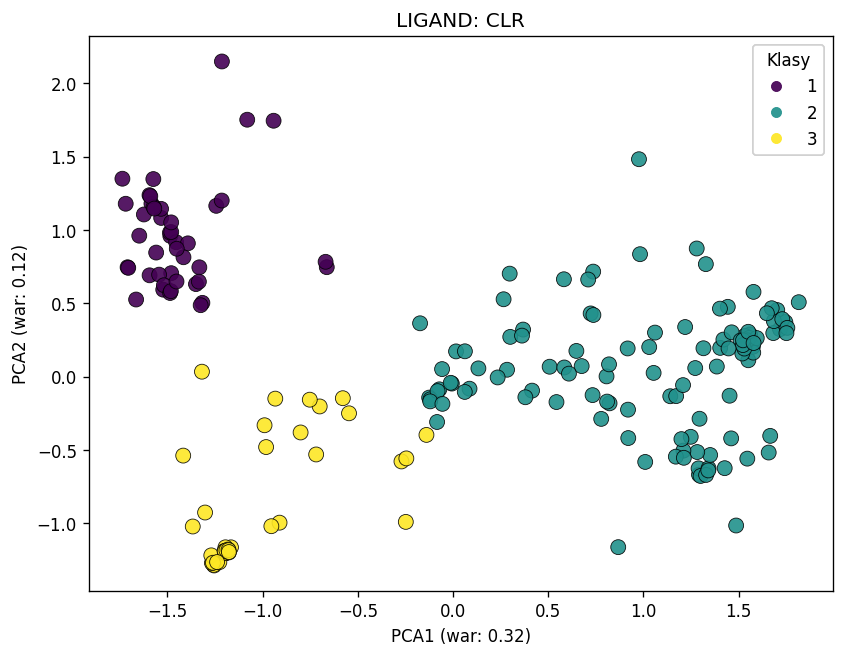

In [10]:
kmeans = KMeans(n_clusters=3, n_init=200)
kmeans.fit(vectors_pca)

classes = [c + 1 for c in kmeans.labels_]

fig, ax = plt.subplots()
fig.set_size_inches((8, 6))
fig.set_dpi(120)
scatter = ax.scatter(vectors_pca[:, 0], vectors_pca[:, 1], c=classes,
                     s=80, cmap="viridis", edgecolor="black", linewidth=0.5, alpha=0.9)
legend = ax.legend(*scatter.legend_elements(),
                   loc="upper right", title="Klasy")
ax.add_artist(legend)
ax.set_xlabel(f"PCA1 (war: {round(pca.explained_variance_ratio_[0], 2)})")
ax.set_ylabel(f"PCA2 (war: {round(pca.explained_variance_ratio_[1], 2)})")
ax.set_title("LIGAND: CLR")
plt.show()


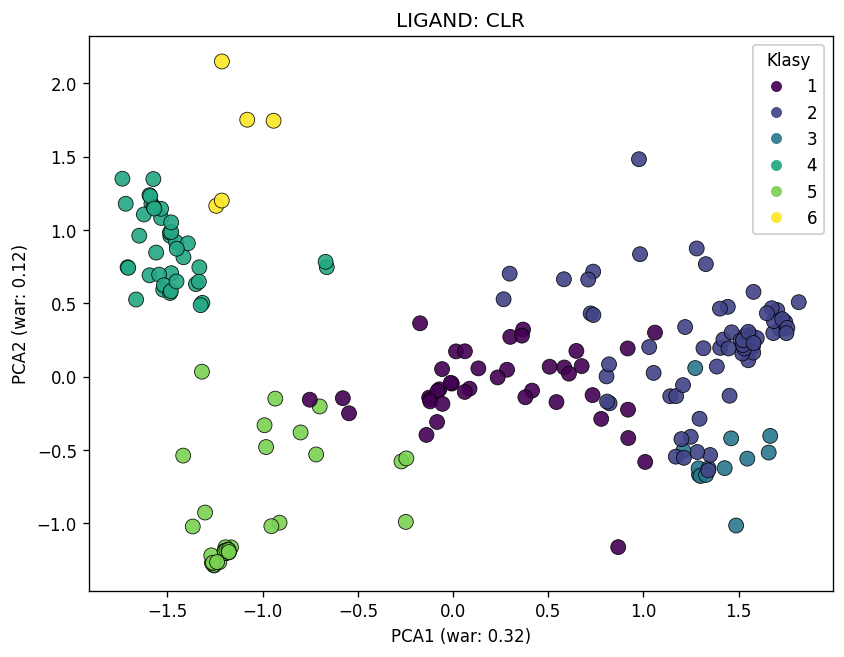

In [11]:
kmeans = KMeans(n_clusters=6, n_init=200)
kmeans.fit(vectors_pca)

classes = [c + 1 for c in kmeans.labels_]

fig, ax = plt.subplots()
fig.set_size_inches((8, 6))
fig.set_dpi(120)
scatter = ax.scatter(vectors_pca[:, 0], vectors_pca[:, 1], c=classes,
                     s=80, cmap="viridis", edgecolor="black", linewidth=0.5, alpha=0.9)
legend = ax.legend(*scatter.legend_elements(),
                   loc="upper right", title="Klasy")
ax.add_artist(legend)
ax.set_xlabel(f"PCA1 (war: {round(pca.explained_variance_ratio_[0], 2)})")
ax.set_ylabel(f"PCA2 (war: {round(pca.explained_variance_ratio_[1], 2)})")
ax.set_title("LIGAND: CLR")
plt.show()

### NADPH:

In [12]:
ligand = "NDP"
pdb_files = glob.glob(f"..\\data\\{ligand}\\*")

vectors = []

for pdb_file in pdb_files:
    vectors += vectorize_ligands(pdb_file, ligand, 48)

c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4909.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4957.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5005.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5184.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 16786.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\

In [13]:
vectors_reshape = np.vstack([vector[3]
                            for vector in vectors if vector[1] < 1750])
vectors_names = [vector[0] for vector in vectors if vector[1] < 1750]

print(f"Liczba znalezionych miejsc wiązania NADPH: {len(vectors)}" )
print(f"Liczba miejsc po odfiltrowaniu: {len(vectors_reshape)}")

Liczba znalezionych miejsc wiązania NADPH: 128
Liczba miejsc po odfiltrowaniu: 113


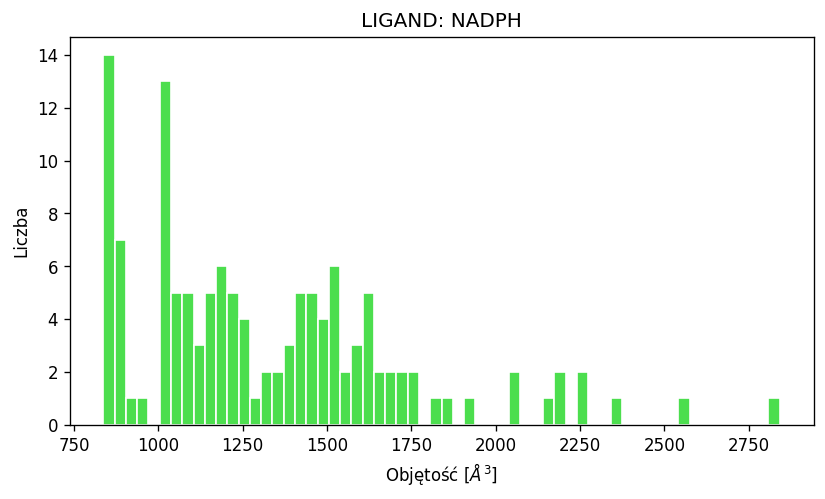

In [14]:
volumes = [vec[1] for vec in vectors]

fig, ax = plt.subplots()
fig.set_size_inches((8, 4.2))
fig.set_dpi(120)

ax.hist(volumes, bins=60, color=(76 / 255, 222 / 255,
        78 / 255), edgecolor="white", linewidth=1)
ax.set_xlabel(r"Objętość $[Å^3]$")
ax.set_ylabel("Liczba")
ax.set_title("LIGAND: NADPH")
plt.show()

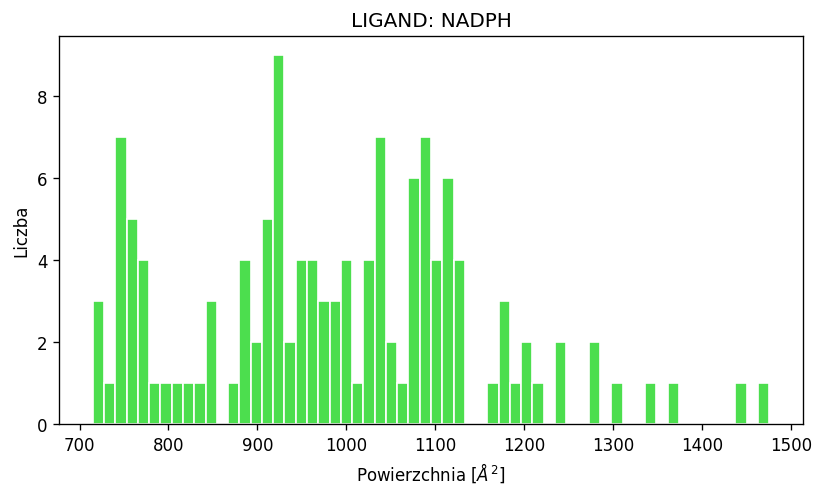

In [15]:
surfaces = [vec[2] for vec in vectors]

fig, ax = plt.subplots()
fig.set_size_inches((8, 4.2))
fig.set_dpi(120)

ax.hist(surfaces, bins=60, color=(76 / 255, 222 / 255,
        78 / 255), edgecolor="white", linewidth=1)
ax.set_xlabel(r"Powierzchnia $[Å^2]$")
ax.set_ylabel("Liczba")
ax.set_title("LIGAND: NADPH")
plt.show()

In [16]:
# Redukcja wymiarowości do 9 wymiarów.
pca = PCA(9)
vectors_pca = pca.fit_transform(vectors_reshape)

total_var = round(np.sum(pca.explained_variance_ratio_) * 100, 1)

print(f"Zachowana wariancja: {total_var}%")

Zachowana wariancja: 80.9%


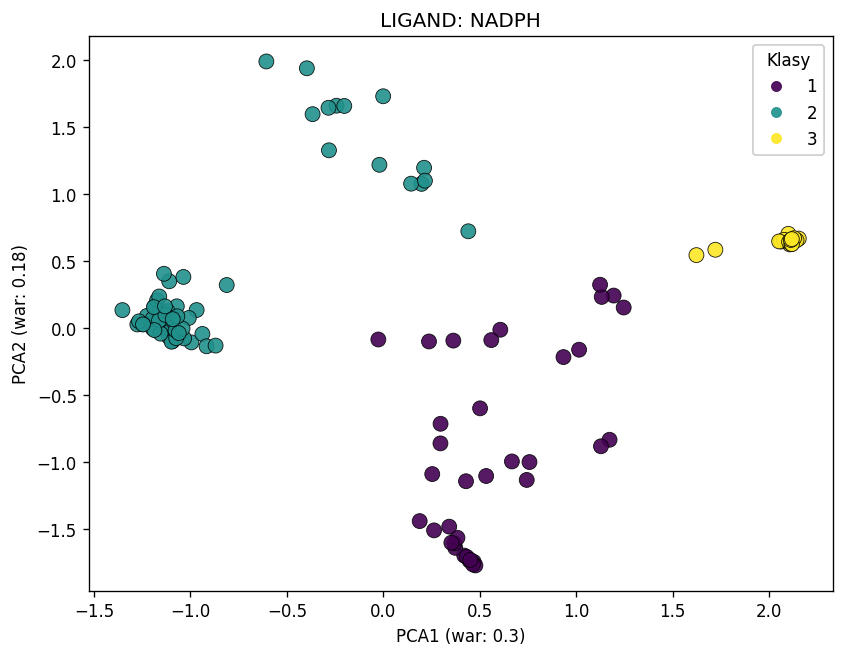

In [17]:
kmeans = KMeans(n_clusters=3, n_init=200)
kmeans.fit(vectors_pca)

classes = [c + 1 for c in kmeans.labels_]

fig, ax = plt.subplots()
fig.set_size_inches((8, 6))
fig.set_dpi(120)
scatter = ax.scatter(vectors_pca[:, 0], vectors_pca[:, 1], c=classes,
                     s=80, cmap="viridis", edgecolor="black", linewidth=0.5, alpha=0.9)
legend = ax.legend(*scatter.legend_elements(),
                   loc="upper right", title="Klasy")
ax.add_artist(legend)
ax.set_xlabel(f"PCA1 (war: {round(pca.explained_variance_ratio_[0], 2)})")
ax.set_ylabel(f"PCA2 (war: {round(pca.explained_variance_ratio_[1], 2)})")
ax.set_title("LIGAND: NADPH")
plt.show()

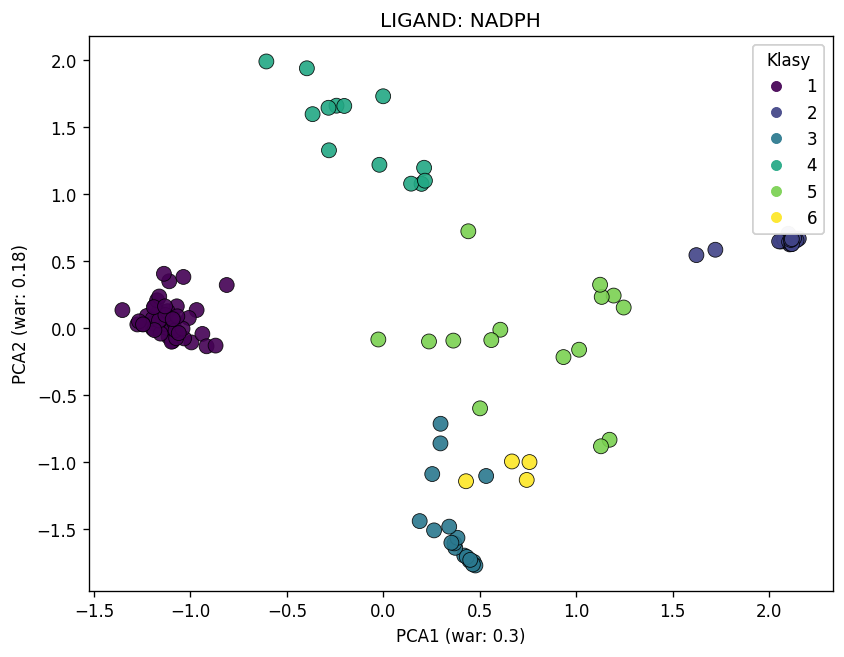

In [18]:
kmeans = KMeans(n_clusters=6, n_init=200)
kmeans.fit(vectors_pca)

classes = [c + 1 for c in kmeans.labels_]

fig, ax = plt.subplots()
fig.set_size_inches((8, 6))
fig.set_dpi(120)
scatter = ax.scatter(vectors_pca[:, 0], vectors_pca[:, 1], c=classes,
                     s=80, cmap="viridis", edgecolor="black", linewidth=0.5, alpha=0.9)
legend = ax.legend(*scatter.legend_elements(),
                   loc="upper right", title="Klasy")
ax.add_artist(legend)
ax.set_xlabel(f"PCA1 (war: {round(pca.explained_variance_ratio_[0], 2)})")
ax.set_ylabel(f"PCA2 (war: {round(pca.explained_variance_ratio_[1], 2)})")
ax.set_title("LIGAND: NADPH")
plt.show()

### ATP:

In [19]:
ligand = "ATP"
pdb_files = glob.glob(f"..\\data\\{ligand}\\*")

vectors = []

for pdb_file in pdb_files:
    vectors += vectorize_ligands(pdb_file, ligand, 31)

c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain S is discontinuous at line 4544.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4546.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain S is discontinuous at line 4578.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4730.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain S is discontinuous at line 4568.
  warnings.warn(
c:\Studia_2022\Nauczanie_maszynowe\Projekt\env\lib\site-packages\Bio\P

In [20]:
vectors_reshape = np.vstack([vector[3]
                            for vector in vectors if vector[1] < 1200])
vectors_names = [vector[0] for vector in vectors if vector[1] < 1200]

print(f"Liczba znalezionych miejsc wiązania ATP: {len(vectors)}" )
print(f"Liczba miejsc po odfiltrowaniu: {len(vectors_reshape)}")

Liczba znalezionych miejsc wiązania ATP: 302
Liczba miejsc po odfiltrowaniu: 242


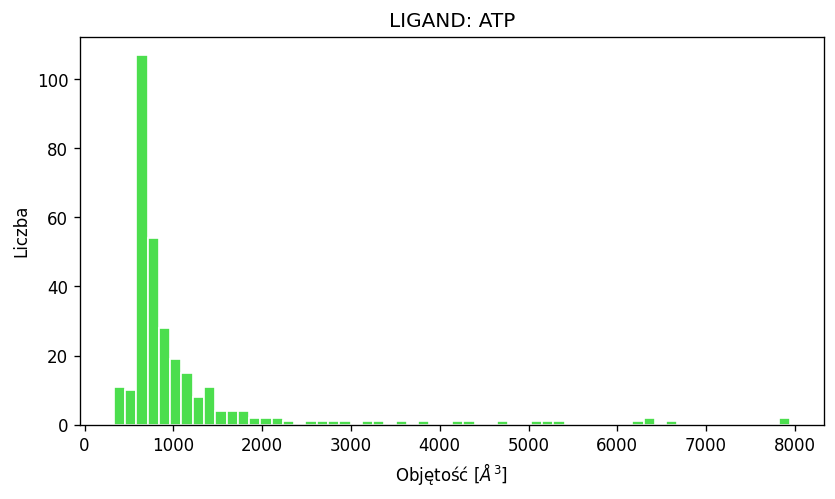

In [21]:
volumes = [vec[1] for vec in vectors]

fig, ax = plt.subplots()
fig.set_size_inches((8, 4.2))
fig.set_dpi(120)

ax.hist(volumes, bins=60, color=(76 / 255, 222 / 255,
        78 / 255), edgecolor="white", linewidth=1)
ax.set_xlabel(r"Objętość $[Å^3]$")
ax.set_ylabel("Liczba")
ax.set_title("LIGAND: ATP")
plt.show()

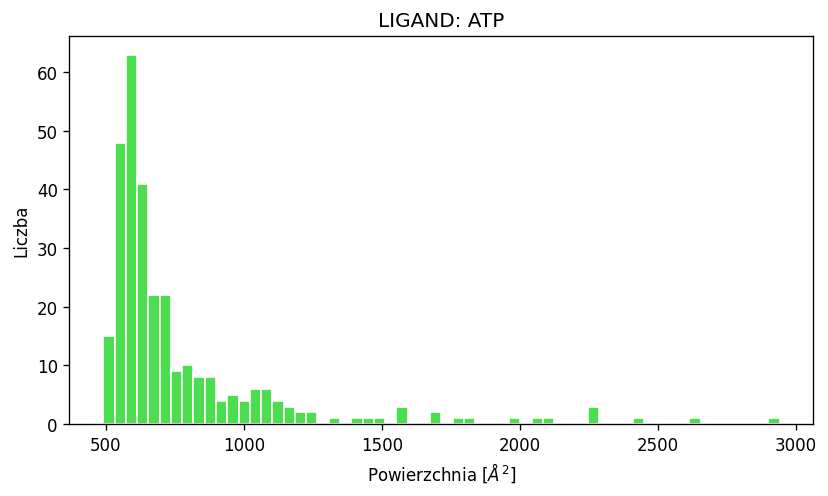

In [22]:
surfaces = [vec[2] for vec in vectors]

fig, ax = plt.subplots()
fig.set_size_inches((8, 4.2))
fig.set_dpi(120)

ax.hist(surfaces, bins=60, color=(76 / 255, 222 / 255,
        78 / 255), edgecolor="white", linewidth=1)
ax.set_xlabel(r"Powierzchnia $[Å^2]$")
ax.set_ylabel("Liczba")
ax.set_title("LIGAND: ATP")
plt.show()

In [23]:
# Redukcja wymiarowości do 17 wymiarów.
pca = PCA(17)
vectors_pca = pca.fit_transform(vectors_reshape)

total_var = round(np.sum(pca.explained_variance_ratio_) * 100, 1)

print(f"Zachowana wariancja: {total_var}%")

Zachowana wariancja: 80.8%


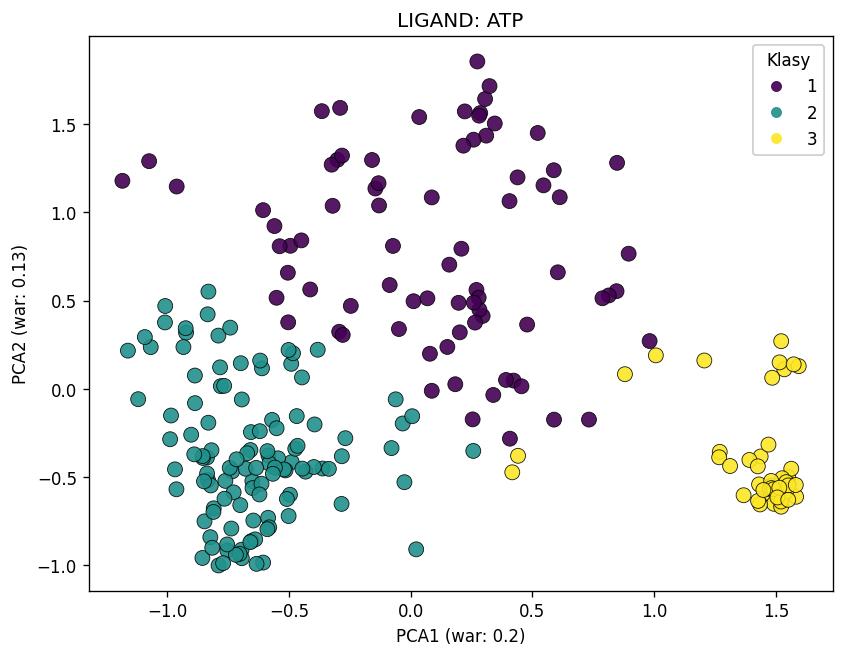

In [24]:
kmeans = KMeans(n_clusters=3, n_init=200)
kmeans.fit(vectors_pca)

classes = [c + 1 for c in kmeans.labels_]

fig, ax = plt.subplots()
fig.set_size_inches((8, 6))
fig.set_dpi(120)
scatter = ax.scatter(vectors_pca[:, 0], vectors_pca[:, 1], c=classes,
                     s=80, cmap="viridis", edgecolor="black", linewidth=0.5, alpha=0.9)
legend = ax.legend(*scatter.legend_elements(),
                   loc="upper right", title="Klasy")
ax.add_artist(legend)
ax.set_xlabel(f"PCA1 (war: {round(pca.explained_variance_ratio_[0], 2)})")
ax.set_ylabel(f"PCA2 (war: {round(pca.explained_variance_ratio_[1], 2)})")
ax.set_title("LIGAND: ATP")
plt.show()

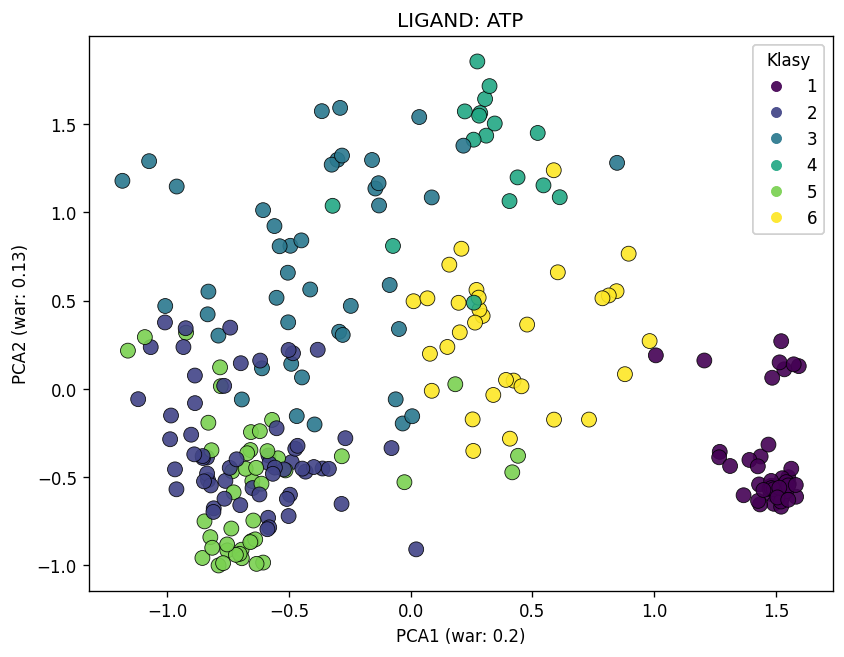

In [25]:
kmeans = KMeans(n_clusters=6, n_init=200)
kmeans.fit(vectors_pca)

classes = [c + 1 for c in kmeans.labels_]

fig, ax = plt.subplots()
fig.set_size_inches((8, 6))
fig.set_dpi(120)
scatter = ax.scatter(vectors_pca[:, 0], vectors_pca[:, 1], c=classes,
                     s=80, cmap="viridis", edgecolor="black", linewidth=0.5, alpha=0.9)
legend = ax.legend(*scatter.legend_elements(),
                   loc="upper right", title="Klasy")
ax.add_artist(legend)
ax.set_xlabel(f"PCA1 (war: {round(pca.explained_variance_ratio_[0], 2)})")
ax.set_ylabel(f"PCA2 (war: {round(pca.explained_variance_ratio_[1], 2)})")
ax.set_title("LIGAND: ATP")
plt.show()

### Wnioski:
- Możliwe jest przeprowadzenie wektoryzacji miejsc wiążących korzystając z reprezentacji struktur w postaci diagramów Woronoja,
- Możliwe jest przeprowadzenie grupowania kieszeni wiążących w przestrzeni zredukowanej (problemem pozostaje dobór liczby grup),
- Separowalność grup w przypadku niektórych ligandów (np. NADPH) jest wyraźna już w pierwszych dwóch wymiarach przestrzeni zredukowanej,
- **Istnieją różne grupy kieszeni wiążących (w obrębie jednego liganda).**